# Retail Promotion Classification-Prediction Problem
## Vasundhara Bagchi, Elizabeth Slesarev, and Paul Beltran 

Through this project, we are aiming to use retail sales data to understand how the stores could run a promotional campaign targeting customers who spend a lot of money in a certain category. 

This project would allow retail stores, particularly one without a lot of resources dedicated to promotional material, to optimize their promotional campaigns by identifying the most effective customer profiles to target with their marketing efforts. This approach can save retailers significant resources and effort by avoiding a standarized approach to promotions, which can be less effective and less efficient. Instead, stores can target specific customer segments based on their preferences in shopping categories, past purchasing behaviors, and other factors to maximize the effectiveness of their promotions.

This particular dataset contains data from various age groups and genders several categories from 10 shopping malls in Istanbul, Turkey. 

Data Source: https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

### Step 1: Data Cleaning and Preprocessing

Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split, 
    cross_val_score,
    StratifiedKFold, 
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier


### Description of the columns: 

1. invoice_no: Invoice number. Nominal. A combination of the letter 'I' and a 6-digit integer uniquely assigned to each operation. <br><br>
2. customer_id: Customer number. Nominal. A combination of the letter 'C' and a 6-digit integer uniquely assigned to each operation.<br><br>
3. gender: String variable of the customer's gender.<br><br>
4. age: Positive Integer variable of the customers age.<br><br>
5. category: String variable of the category of the purchased product.<br><br>
6. quantity: The quantities of each product (item) per transaction. Numeric.<br><br>
7. price: Unit price. Numeric. Product price per unit in Turkish Liras (TL).<br><br>
8. payment_method: String variable of the payment method (cash, credit card or debit card) used for the transaction.<br><br>
9. invoice_date: Invoice date. The day when a transaction was generated.<br><br>
10. shopping_mall: String variable of the name of the shopping mall where the transaction was made.<br><br>

### Reading in the data 

In [2]:
df = pd.read_csv('customer_shopping_data.csv')
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Feature Engineering

For our purposes, we are not using 'invoice_no', 'customer_id', 'payment_method', 'invoice_date', 'shopping_mall' data attributes, and are therefore dropping 
it from the dataset. We also want to restrict this demonstration to a couple of the main categories, so we are dropping the other ones, including Toys, Souveniers, Books, Shoes. 

In [3]:
# grabbing columns that are useful and dropping all else
df.drop(['invoice_no', 'customer_id', 'payment_method', 'invoice_date', 'shopping_mall'], axis=1, inplace=True)

# dropping rows we dont care about, like toys
df.drop(df[df['category'] == 'Toys'].index, inplace = True)
df.drop(df[df['category'] == 'Souvenir'].index, inplace = True)
df.drop(df[df['category'] == 'Books'].index, inplace = True)
df.drop(df[df['category'] == 'Shoes'].index, inplace = True)


We notice that there is a price column and a quantity column, but that is not as meaningful as a total price column which will be an useful feature in our problem. We are thus calculating the new feature, **total price**, by multiplying the price and quantity columns. Once we add in this new feature, we drop the price and quantity columns as they do not provide us any new information. 

In [4]:
# recalculating price column to include totals
df['total_price'] = (df['price'] * df['quantity'])
df.drop(['quantity', 'price'], axis=1, inplace=True)
df.head()

,gender,age,category,total_price
0,Female,28,Clothing,7502.00
2,Male,20,Clothing,300.08
5,Female,28,Clothing,7502.00
6,Female,49,Cosmetics,40.66
7,Female,32,Clothing,1200.32


In [40]:
df['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Technology          4996
Name: category, dtype: int64

### Visualizing the cleaned data 

One of the first pieces we want to visualize and compare is the total amount of money spent by females vs. men.

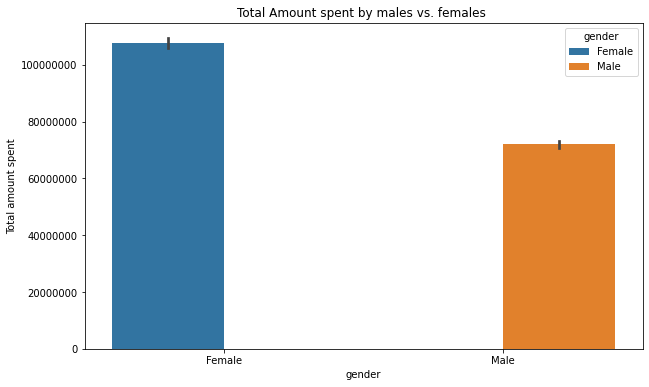

In [5]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='gender',y='total_price',hue = 'gender',estimator = sum)
plt.ylabel('Total amount spent')
plt.title('Total Amount spent by males vs. females ')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

It is evident that the overall total amount of money spent by females is considerably higher. 

Next, we want to comapare the amount of money spent per category by males vs. females 

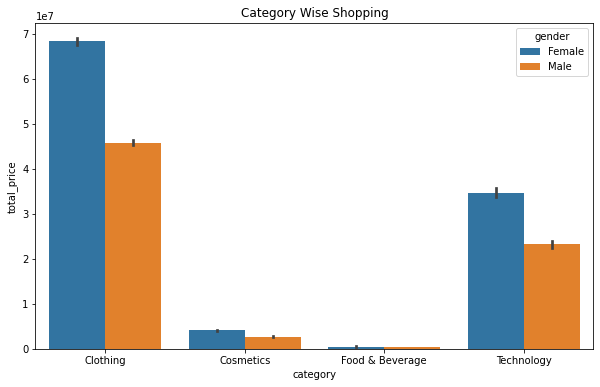

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = sum)
plt.title('Category Wise Shopping')
plt.show()

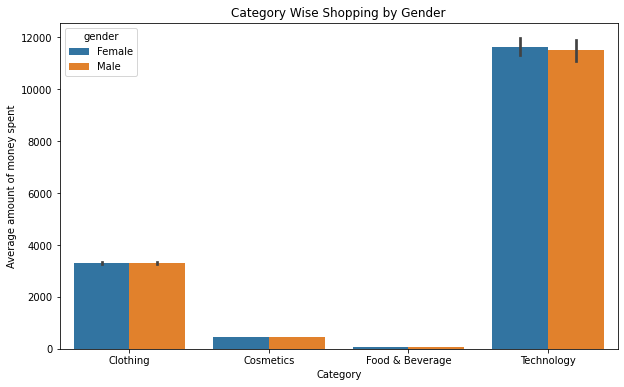

In [7]:
plt.figure(figsize=(10,6))
ax = sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = 'mean')
ax.set(xlabel='Category',
       ylabel='Average amount of money spent',
       title='Category Wise Shopping by Gender')
plt.show()

In [8]:
# checking average price spent by gender per category
avg_price_spent_per=df.groupby(['gender','category'], as_index=False)['total_price'].mean()
avg_age_per=df.groupby(['gender','category'], as_index=False)['age'].mean()
print(avg_price_spent_per)
print("\n",avg_age_per)

   gender         category   total_price
0  Female         Clothing   3304.846775
1  Female        Cosmetics    448.376245
2  Female  Food & Beverage     57.396933
3  Female       Technology  11630.308621
4    Male         Clothing   3306.475999
5    Male        Cosmetics    452.312985
6    Male  Food & Beverage     57.637718
7    Male       Technology  11509.875931

    gender         category        age
0  Female         Clothing  43.381948
1  Female        Cosmetics  43.571665
2  Female  Food & Beverage  43.489209
3  Female       Technology  43.249581
4    Male         Clothing  43.449946
5    Male        Cosmetics  43.594160
6    Male  Food & Beverage  43.155727
7    Male       Technology  43.544417


We quickly find that although there is a lot of difference is total amount spent per category, there is very little difference in when comparing males vs. females within each category. For example, for the Technology category, Males spent an average of 11509.88 Lira wheras females spent 11630.31 Lira and in the Clothing category, males spent an average of 3306.48  Lira whereas females spent an average of 3304.85 Lira. 

### Creating class labels for our dataset 

After visualizing and understanding our dataset, we will now be creating class labels for our dataset. We want to have 3 labels - Yes, No, and Maybe which represent if we should market to this person based on their shopping habits - i.e amount of money spent in a particular category. 

Our cutoffs of creating each of these labels will be based on total cost percentiles per category - 


1. **Yes** - This person's total cost in a certain category is more than the 75 percentile of total money spent in that certain category, therfore, we will defintely want to market to these people. 


2. **Maybe** - This person's total cost in a certain category is less than the 75 percentile but more than the 25 percentile of total money spent in that certain category, therfore, we will may want to market to these people, but will want to give higher priority to people who have spent more money. 


3. **No** -  This person's total cost in a certain category is less than the 25 percentile but more than the median of total money spent in that certain category, therfore, we do not want to market to these people and conserve our resources instead. 

In [9]:
df.groupby(['gender','category'], as_index=False)['total_price'].describe()

gender  0     Female
        1     Female
        2     Female
        3     Female
        4       Male
              ...   
max     3    26250.0
        4     7502.0
        5     1016.5
        6     130.75
        7    26250.0
Length: 80, dtype: object

In [10]:
df.groupby(['gender','category'], as_index=False)['age'].describe()

gender  0    Female
        1    Female
        2    Female
        3    Female
        4      Male
              ...  
max     3      69.0
        4      69.0
        5      69.0
        6      69.0
        7      69.0
Length: 80, dtype: object

In [11]:
# creating the class label
# label -> ['maybe', 'no', 'yes']
def assignNewLabels(row):
    # for book shoppers
    if row['category'] == "Technology" and row["total_price"] > 16800:
        return "yes"
    elif row['category'] == "Technology" and row["total_price"] <= 4200:
        return "no"
    elif row['category'] == "Technology" and row["total_price"] > 4200.0 and row["total_price"] <= 16800:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Clothing" and row["total_price"] > 4801.28:
        return "yes"
    elif row['category'] == "Clothing" and row["total_price"] <= 1200.32:
        return "no"
    elif row['category'] == "Clothing" and row["total_price"] > 1200.32 and row["total_price"] <= 4801.28:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Cosmetics" and row["total_price"] > 650.56:
        return "yes"
    elif row['category'] == "Cosmetics" and row["total_price"] <= 162.64:
        return "no"
    elif row['category'] == "Cosmetics" and row["total_price"] > 162.64 and row["total_price"] <= 650.56:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Food & Beverage" and row["total_price"] > 83.68:
        return "yes"
    elif row['category'] == "Food & Beverage" and row["total_price"] <= 20.92:
        return "no"
    elif row['category'] == "Food & Beverage" and row["total_price"] > 20.92 and row["total_price"] <= 83.68:
        return "maybe"

In [12]:
df['Should_We_Market'] = df.apply(lambda row: assignNewLabels(row), axis=1)
#df = df[df['category'] == 'Clothing']
df.head()

,gender,age,category,total_price,Should_We_Market
0,Female,28,Clothing,7502.00,yes
2,Male,20,Clothing,300.08,no
5,Female,28,Clothing,7502.00,yes
6,Female,49,Cosmetics,40.66,no
7,Female,32,Clothing,1200.32,no


### Starting the Machine Learning Process 

We are creating one hot encoded labels for each gender and category features as we are doing multilclass classification. 

In [13]:
df_dummy = pd.get_dummies(df[['gender', 'category', 'age', 'total_price']])
df_dummy.head()


,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
0,28,7502.00,1,0,1,0,0,0
2,20,300.08,0,1,1,0,0,0
5,28,7502.00,1,0,1,0,0,0
6,49,40.66,1,0,0,1,0,0
7,32,1200.32,1,0,1,0,0,0


In [14]:
# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)
df_dummy.drop(['age'], axis=1, inplace=True)

In [15]:
# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)
df_dummy.drop(['total_price'], axis=1, inplace=True)


In [16]:
df_dummy.head()

,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology,normalized_age,normalized_price
0,1,0,1,0,0,0,0.196078,0.285648
2,0,1,1,0,0,0,0.039216,0.011235
5,1,0,1,0,0,0,0.196078,0.285648
6,1,0,0,1,0,0,0.607843,0.001350
7,1,0,1,0,0,0,0.274510,0.045536


### Gaussian Naive Bayes with labels = yes or no or maybe

In [17]:
X = df_dummy
y = df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(69356, 8) (69356,)


Accuracy: 0.6019378280177634
F1 Score: 0.6583024746746252


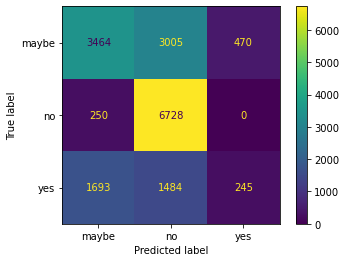

In [18]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

We can see that accuracy is low, and we realize further that this is wrong.
List reasons here: 
Now we will repurpose our statement to classify shopper's spending categories based on spending habits and gender and age.

## Random Forrest Classification for Feature Selection

In [19]:
df_dummy = pd.get_dummies(df[['gender', 'age', 'total_price']])
df_dummy.head()

,age,total_price,gender_Female,gender_Male
0,28,7502.00,1,0
2,20,300.08,0,1
5,28,7502.00,1,0
6,49,40.66,1,0
7,32,1200.32,1,0


In [20]:
# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)

# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)
df_dummy.drop(['total_price', 'age'], axis=1, inplace=True)
df_dummy.head()


,gender_Female,gender_Male,normalized_age,normalized_price
0,1,0,0.196078,0.285648
2,0,1,0.039216,0.011235
5,1,0,0.196078,0.285648
6,1,0,0.607843,0.001350
7,1,0,0.274510,0.045536


In [21]:
X = df_dummy
y = df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. Feature normalized_price (0.9985856408241461)
2. Feature normalized_age (0.0012827356130951416)
3. Feature gender_Female (6.738941238558885e-05)
4. Feature gender_Male (6.423415037316197e-05)


According to this dataset, gender doesnt make a big difference in classififcation whcih lines up with our earlier observations...

### Gaussian Naive Bayes with new labels based on categories

In [22]:
# dropping useless features according to Random Forest
df_dummy.drop(['gender_Female', 'gender_Male'], axis=1, inplace=True)

In [23]:
X = df_dummy
y = df.category

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(69356, 2) (69356,)


Accuracy: 0.8121575638733491
F1 Score: 0.8137622111213028


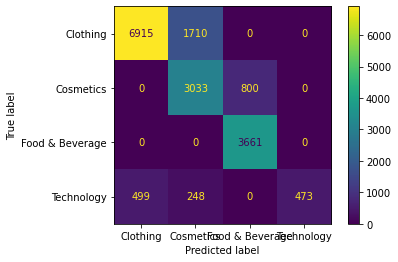

In [24]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

Accuracy is a lot better because of .... 

### Stratified K-fold cross validation for Naive Bayes without Gender features

In [25]:
kf = StratifiedKFold(n_splits=10, random_state=40, shuffle=True) 
accscore = []
classifier2 = GaussianNB()


for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    classifier2.fit(X_train, y_train.values.ravel())
    Y_pred = classifier2.predict(X_test)

     
    acc2 = accuracy_score(y_test, Y_pred)
    accscore.append(acc2)
     
avgscore = sum(accscore)/10
 
print("Accuracy from each fold using Naive Bayes without Gender features = \n" + str(accscore))
print("\nAverage accuracy using Naive Bayes without Gender features = \n" + str(avgscore))
print()


Accuracy from each fold using Naive Bayes without Gender features = 
[0.81199538638985, 0.8184832756632064, 0.8171856978085352, 0.8114186851211073, 0.8124279123414071, 0.828719723183391, 0.8152847873107426, 0.8116798846431147, 0.8108147080028839, 0.813410237923576]

Average accuracy using Naive Bayes without Gender features = 
0.8151420298387814



Hmmm, seems like the gender feature really did not matter in the long run. Lets try another classification technique instead!

### Neural Networks:

In [26]:
# one hot encode the category classes
df_dummy = pd.get_dummies(df[['gender', 'age', 'total_price']])
df_y_dummy = pd.get_dummies(df[['category']])
df_y_dummy.head()

,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
0,1,0,0,0
2,1,0,0,0
5,1,0,0,0
6,0,1,0,0
7,1,0,0,0


In [27]:
# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)

# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)

# drop converted columns
df_dummy.drop(['total_price', 'age'], axis=1, inplace=True)

df_dummy.head()

,gender_Female,gender_Male,normalized_age,normalized_price
0,1,0,0.196078,0.285648
2,0,1,0.039216,0.011235
5,1,0,0.196078,0.285648
6,1,0,0.607843,0.001350
7,1,0,0.274510,0.045536


In [28]:
# Split the data into features and target
X = df_dummy
y = df_y_dummy

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.8950


### KNN 

In [43]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = , metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, Y_pred)
print ("Accuracy:" + str(acc))
f1 = f1_score(Y_pred, y_test, average="weighted")
print ("F1 score:" + str(f1))



Accuracy:0.9976211072664359
F1 score:0.9979247239363281


## Conclusion

## Policy Recommendation 
The performance of these models could be improved by: 